In [1]:
import keras
from IPython.display import display, HTML
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

from math import pi
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file

np.random.seed(42)
output_notebook()

Using TensorFlow backend.


Loading BokehJS ...

In [2]:
HOURS_IN_DAY = 24
MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
AGGREGATION_PERIOD = 30 #Model uses 30 minutes candles

DAY_WINDOW = int(HOURS_IN_DAY * MINUTES_IN_HOUR / AGGREGATION_PERIOD)

In [3]:
# Force CPU usage
import tensorflow as tf
from keras import backend as K

num_cores = 8

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

## Helper functions

In [4]:
def aggregate_market_values(dataframe, aggregation_period, unix_time=False):
    """
    timestamp / open / high / low / close / volume btc / volume currency / weighted price
    """    
    data = dataframe.copy()
    aggregation_factor = aggregation_period * SECONDS_IN_MINUTE
    
    if not unix_time:
        data.Timestamp = data.Timestamp.astype(np.int64) // 10**9
    
    data = data.groupby(data.Timestamp // aggregation_factor).agg({
        'Open' : 'first',
        'High' : np.max,
        'Low' : np.min,
        'Close' : 'last',
        'Volume_(BTC)' : np.sum ,
        'Volume_(Currency)' : np.sum,
        'Weighted_Price' : np.mean,
    }).reset_index()
    
    data.Timestamp *= aggregation_factor
    
    if not unix_time:
        data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    
    return data

def first_in_window(dataframe, aggregation_period, unix_time=False):
    """
    timestamp / open / high / low / close / volume btc / volume currency / weighted price
    """    
    data = dataframe.copy()
    aggregation_factor = aggregation_period * SECONDS_IN_MINUTE
    
    if not unix_time:
        data.Timestamp = data.Timestamp.astype(np.int64) // 10**9
            
    data = data.groupby(data.Timestamp // aggregation_factor).first().reset_index(drop=True)
            
    if not unix_time:
        data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    
    return data
    
def make_plot_figure(plot_title, xlabel, ylabel, height=600):
    p = figure(x_axis_type="datetime", plot_width=950, plot_height=height, title = plot_title)
    p.xaxis.major_label_orientation = pi/4
    p.xaxis.axis_label = xlabel
    p.xaxis.axis_label_text_font_style='normal'
    p.yaxis.axis_label = ylabel
    p.yaxis.axis_label_text_font_style='normal'
    p.grid.grid_line_alpha=0.3
    
    return p

## Data preparation

In [5]:
df_raw_part1 = pd.read_csv('Data/bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
df_raw_part2 = pd.read_csv('Data/bitstampUSD_30-min_data_january.csv', date_parser=True)

# Aggregate first part of data into chunks of 30 mins, second part already aggregated
df_p1 = aggregate_market_values(df_raw_part1, 30, unix_time=True)
df_p1.Timestamp = pd.to_datetime(df_p1.Timestamp, unit='s')

df_p2 = df_raw_part2
df_p2.Timestamp = pd.to_datetime(df_p2.Timestamp)

df_raw = pd.concat([df_p1, df_p2]).reset_index(drop=True)

In [6]:
df_plot = df_raw.copy()

aggregation_factor = 2 * 7 * 24 * 60 #2W candles

df_plot = aggregate_market_values(df_plot, aggregation_factor)

inc = df_plot.Close >= df_plot.Open
dec = df_plot.Open > df_plot.Close
barWidth = 0.66 * aggregation_factor * 60 * 1000 # 30 minutes in ms

p = make_plot_figure("Bitcoin closing prices", "Time", "Bitcoin price in USD")
p.segment(df_plot.Timestamp, df_plot.High, df_plot.Timestamp, df_plot.Low, color="black")
p.vbar(df_plot.Timestamp[inc], barWidth, df_plot.Open[inc], df_plot.Close[inc], fill_color="#48D922", line_color="black")
p.vbar(df_plot.Timestamp[dec], barWidth, df_plot.Open[dec], df_plot.Close[dec], fill_color="#FF2828", line_color="black")

show(p)

## Features

In [7]:
def add_MA_n_days_age(num_days):
    num_days_str = str(num_days)
    df[['MA_'+num_days_str,'High_MA_'+num_days_str,'Low_MA_'+num_days_str,'Close_MA_'+num_days_str]] = df[['Open','High','Low','Close']].rolling(window=day_window * num_days).mean()

def add_prices_n_periods_ago(data, periods, step=DAY_WINDOW):
    return data['Smoothed_Price'].copy().shift(step * periods)

def dummy_increased_since(data, n, step=DAY_WINDOW):
    """
    1 if price increased since n * step, 0 otherwise
    """
    return 1 * (data['Smoothed_Price'] > data['Smoothed_Price'].shift(int(step * n)))

def dummy_piecewise_increased_since(data, n, interval, step=DAY_WINDOW):
    """
    1 if price increased between n * step - interval and n * step, 0 otherwise
    """
    return 1 * (data['Smoothed_Price'].shift(int(step * n)) > data['Smoothed_Price'].shift(int(step * (n + interval))))

def mean_square_loss(predicted_labels, true_labels):
    assert len(predicted_labels) == len(true_labels)
    return np.mean((predicted_labels - true_labels)**2)

def accuracy(x,y):
    return np.mean(x==y)

## Momentum-based oscillators et other indicators

In [8]:
def RSI(df, gain_column='Close', period=14):
    data = pd.DataFrame(df[gain_column].copy())
    
    #Compute differences
    data['delta'] = data[gain_column] - data.shift(1)[gain_column]
    
    #Compute gains and losses
    data['gain'] = data[data['delta'] >= 0]['delta']
    data['loss'] = data[data['delta'] <= 0]['delta']
    data['loss'] = -data['loss']
    data['gain'].fillna(0.0, inplace = True)
    data['loss'].fillna(0.0, inplace = True)
    
    #Compute average of gains and losses
    data['avg_gain'] = data['gain'].rolling(period).mean()
    data['avg_loss'] = data['loss'].rolling(period).mean()
    
    #Compute relative strength
    data['RS'] = data['avg_gain'] / data['avg_loss']
    
    return 100 - 100.0/(1.0 + data.RS)
    
def EMA(data, s):    
    return data.ewm(span=s, adjust=False).mean()

def MACD(df, price_column='Close', period1=12, period2=26, smooth_factor=9):
    
    data = df.copy()
    
    data['EMA_'+str(period1)] = EMA(data[price_column], period1)
    data['EMA_'+str(period2)] = EMA(data[price_column], period2)
    
    data['MACD_Line'] = data['EMA_'+str(period1)] - data['EMA_'+str(period2)]
    
    data['Signal_Line'] = EMA(data['MACD_Line'], smooth_factor)
    
    data['MACD_Histogram'] = data['MACD_Line'] - data['Signal_Line']
    
    return data
    
def BB(dataframe, price_column='Close', period = 20):
    df = dataframe.copy()
    
    #Compute middle Band
    df['MA'] = df[price_column].rolling(period).mean()
    
    # Compute std
    df['std'] = df[price_column].rolling(period).std()

    #Compute Upper Band
    df['Upper'] = df['MA'] + 2*df['std']
    
    #Compute Lower Band
    df['Lower'] = df['MA'] - 2*df['std']
    return df

def ATR(df, period=14):
    data = df.copy()
    
    data['v1'] = data.High - data.Low
    data['v2'] = (data.High - data.shift(1).Close).apply(abs)
    data['v3'] = (data.Low - data.shift(1).Close).apply(abs)
    data['True_Range'] = data[['v1','v2','v3']].max(axis=1)
    
    
    return EMA(data.True_Range, period)


def DM(df, period_di=14, period_adx=14):
    data = df.copy()
    data['UpMove'] = data.High - data.shift(1).High
    data['DownMove'] = data.shift(1).Low - data.Low
    
    #Compute directional movement
    data['pDM'] = 0
    data['mDM'] = 0
    data.loc[(data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), 'pDM'] = data.loc[(data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), 'UpMove']
    data.loc[(data['UpMove'] < data['DownMove']) & (data['DownMove'] > 0), 'mDM'] = data.loc[(data['UpMove'] < data['DownMove']) & (data['DownMove'] > 0), 'DownMove']

    data['pDI'] = 100.0 * EMA(data['pDM'], period_di) / data['ATR']
    data['mDI'] = 100.0 * EMA(data['mDM'], period_di) / data['ATR']
    
    data['ADX'] = EMA(100.0 * ((data['pDI'] - data['mDI']).apply(abs) / (data['pDI'] + data['mDI'])), period_adx)
    
    return data

# Feature creation 

In [9]:
SMOOTHING_PERIOD = int(0.5 * 2 * 24) # 12h
SHIFTING_PERIOD = 0 #SMOOTHING_PERIOD

df_processed = df_raw.copy()

# Unused features
#df_processed['Smoothed_Price'] = EMA(df_processed.Close, 21)
#df_processed['Inc_1_day'] = dummy_increased_since(df_processed, 1)
#df_processed['Inc_12_hours'] = dummy_increased_since(df_processed, 0.5)
#df_processed['Inc_6_hour'] = dummy_increased_since(df_processed, 0.25)
#df_processed['Inc_1_hour_30min'] = dummy_increased_since(df_processed, 3, 1)
#df_processed['PInc_30-60'] = dummy_piecewise_increased_since(df_processed, 1, 1, 1)
#df_processed['PInc_60-90'] = dummy_piecewise_increased_since(df_processed, 2, 1, 1)

# Lagged data
df_processed['Smoothed_Price'] = (df_processed.Weighted_Price).rolling(SMOOTHING_PERIOD).mean()
df_processed['Inc_1_hour'] = dummy_increased_since(df_processed, 2, 1)
df_processed['Inc_30_min'] = dummy_increased_since(df_processed, 1, 1)

# Indicators
df_processed = df_processed.reset_index(drop=True)
df_processed = MACD(df_processed)
df_processed = BB(df_processed)
df_processed['RSI'] = RSI(df_processed, gain_column='Close')
df_processed['ATR'] = ATR(df_processed)
df_processed = DM(df_processed)

df_processed = df_processed.dropna(how='any')

In [10]:
last_n_points = 5000

p = make_plot_figure("Bitcoin Closing Prices", "Time", "Price in USD")
p.line(df_processed.Timestamp[-last_n_points:], df_processed.Open[-last_n_points:], line_alpha=0.6, line_color="black", legend='30m closing price')
p.line(df_processed.Timestamp[-last_n_points:], df_processed.Smoothed_Price[-last_n_points:], line_width=2, line_alpha=1, line_color="red", legend=("Rolling avg. "+str(0.5*SMOOTHING_PERIOD)))
show(p)

# Objective 

We aim to predict price changes across intervals of 24 hours. More specifically, at the end of each day, the model should predict the price of Bitcoin in the following 24 hours.

## Simple model

To assess the performance of our model, we devise a simple naïve model as a benchmark. Our simple model looks at the price change in the last 24H and assume that this change will repeat in the next 24H. More specifically, let $P_p, P_c, P_f$ be respectively the previous, current and future price of Bitcoin (in intervals of 24 hours). We have:

$$ P_f = P_c + (P_c - P_p) $$

In [11]:
def naive_predict_price_diff(data):  
    ret = data.copy()
    P_c = ret.Smoothed_Price
    P_p = ret.Smoothed_Price.shift(1)
    
    ret['Simple_Predicted_Price'] = P_c - P_p
    return ret

def create_labels(data, step_size=1):
    return data.Smoothed_Price.shift(-step_size) - data.Smoothed_Price

## Dataset splitting and standardization

In [12]:
def split_dataset(data, fraction):
    l = len(data)
    
    train = data[0 : int(l * fraction)]
    test = data[ int(l*fraction) :]
    
    return train, test

STANDARDIZE = True
LOG = False

df = df_processed.copy()
df['Label'] = create_labels(df, step_size = DAY_WINDOW)
df = df.dropna()

if LOG:
    df.Smoothed_Price = df.Smoothed_Price.apply(lambda x: np.log(x))

if STANDARDIZE:
    timestamps = df.Timestamp
    labels = df.Label
    df = df.drop('Timestamp',1)
    df = (df-df.mean())/df.std()
    df.Label = labels
    df['Timestamp'] = timestamps


train, test = split_dataset(df, 0.9)
train_x = train.drop('Label',1)
train_y = train['Label']
train_bin = train_y > 0
test_x = test.drop('Label',1)
test_y = test['Label']
test_bin = test_y > 0

display(train[0:1])
display(train[-1:])
display(test[0:1])

,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_hour,Inc_30_min,...,ATR,UpMove,DownMove,pDM,mDM,pDI,mDI,ADX,Label,Timestamp
23,-0.461407,-0.460787,-0.462088,-0.461392,-0.110575,-0.306073,-0.461424,-0.461414,-1.088759,-1.087643,...,-0.333572,-0.002267,0.001924,-0.158804,-0.149377,5.771799,-1.591379,4.186401,0.695394,2011-12-31 19:00:00


,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_hour,Inc_30_min,...,ATR,UpMove,DownMove,pDM,mDM,pDI,mDI,ADX,Label,Timestamp
98598,0.977494,0.967788,0.982409,0.972705,-0.533358,-0.252306,0.974986,0.954272,0.918468,0.919411,...,0.538396,-0.678151,-0.252999,-0.158804,-0.149377,0.390225,-0.395358,-0.884614,33.134366,2017-08-19 22:00:00


,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Weighted_Price,Smoothed_Price,Inc_1_hour,Inc_30_min,...,ATR,UpMove,DownMove,pDM,mDM,pDI,mDI,ADX,Label,Timestamp
98599,0.980659,0.980006,0.985923,0.974754,-0.236798,0.281436,0.98593,0.955662,0.918468,0.919411,...,0.537194,1.239696,-0.30032,1.575841,-0.149377,0.926421,-0.553397,-0.746392,30.016889,2017-08-19 22:30:00


## Simple model performance

In [13]:
simple_predicted_labels = naive_predict_price_diff(df).loc[test_x.index]
simple_predicted_labels['Binary'] = 1 * (simple_predicted_labels.Simple_Predicted_Price > 0)

print(mean_square_loss(simple_predicted_labels.Simple_Predicted_Price, test_y))
print(accuracy(simple_predicted_labels.Binary, test_bin))

358192.02336019784
0.635429206408


In [14]:
last_n_points = -300
s = 10
n = 5
points = simple_predicted_labels[last_n_points::n]

correct_buy_points = points[(simple_predicted_labels.Binary[last_n_points::n] == 1) & (simple_predicted_labels.Binary[last_n_points::n] == test_bin[last_n_points::n])]
incorrect_buy_points = points[(simple_predicted_labels.Binary[last_n_points::n] == 1) & (simple_predicted_labels.Binary[last_n_points::n] != test_bin[last_n_points::n])]
correct_sell_points = points[(simple_predicted_labels.Binary[last_n_points::n] == 0) & (simple_predicted_labels.Binary[last_n_points::n] == test_bin[last_n_points::n])]
incorrect_sell_points = points[(simple_predicted_labels.Binary[last_n_points::n] == 0) & (simple_predicted_labels.Binary[last_n_points::n] != test_bin[last_n_points::n])]

p = make_plot_figure("BTC Price Predictions", "Time", "Standardized Bitcoin price in USD")

p.line(test_x.Timestamp[last_n_points:], test_x.Smoothed_Price[last_n_points:], line_width=2, line_color='black',  line_alpha=1, legend="12h MA")
p.line(test_x.Timestamp[last_n_points:], test_x.Close[last_n_points:], line_width=2, line_color='black',  line_alpha=0.3, legend="Closing price")
p.triangle(correct_buy_points.Timestamp[::], correct_buy_points.Smoothed_Price[::], color="#00bb00", size=s, legend="Correct buys")
p.triangle(incorrect_buy_points.Timestamp[::], incorrect_buy_points.Smoothed_Price[::], color="#ff0000", size=s,legend="Incorrect buys")
p.inverted_triangle(correct_sell_points.Timestamp[::], correct_sell_points.Smoothed_Price[::], color="#00bb00", size=s,legend="Correct sells")
p.inverted_triangle(incorrect_sell_points.Timestamp[::], incorrect_sell_points.Smoothed_Price[::], color="#ff0000" , size=s,legend="Incorrect sells")
p.xaxis.axis_label="Time"
show(p)

## Neural network

In [15]:
# For plot

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    #plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax2.plot(history.history['binary_accuracy'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['val_binary_accuracy'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Selecting useful features

In [16]:
to_drop = ['Timestamp', 'Open', 'Close', 'High', 'Low', 'Weighted_Price', 'Volume_(Currency)',
          'pDM','mDM']
train_x_nn = train_x.copy().drop(to_drop,1)
test_x_nn = test_x.copy().drop(to_drop,1)

train_y_nn = (train_y > 0).astype(int)
test_y_nn = (test_y > 0).astype(int)


print("% of 1 in train: " + str(np.sum(train_y_nn == 1) / len(train_y)))
print("% of 1 in test: " + str(np.sum(test_y_nn == 1) / len(test_y)))
print(test_y_nn.dtypes)
display(train_x_nn.head(1))
display(train_y_nn.head(1))

% of 1 in train: 0.563324483958
% of 1 in test: 0.536623761459
int32


,Volume_(BTC),Smoothed_Price,Inc_1_hour,Inc_30_min,EMA_12,EMA_26,MACD_Line,Signal_Line,MACD_Histogram,MA,std,Upper,Lower,RSI,ATR,UpMove,DownMove,pDI,mDI,ADX
23,-0.110575,-0.461414,-1.088759,-1.087643,-0.461434,-0.461437,-0.011538,-0.012874,0.001979,-0.461408,-0.310624,-0.458365,-0.464443,2.888959,-0.333572,-0.002267,0.001924,5.771799,-1.591379,4.186401


23    1
Name: Label, dtype: int32

## Training the model

In [17]:
model = Sequential()
model.add(Dense(128, kernel_initializer='normal', input_dim=len(train_x_nn.columns), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, kernel_initializer='normal', input_dim=len(train_x_nn.columns), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.SGD(lr=0.005, momentum=0.01, decay=0, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

history = model.fit(train_x_nn, train_y_nn, epochs = 40, batch_size=200, verbose=1, validation_data = (test_x_nn, test_y_nn))
scores = model.evaluate(test_x_nn, test_y_nn, verbose=0)

print(scores)

Train on 97182 samples, validate on 10799 samples
Epoch 1/40
97182/97182 [==============================] - 3s 27us/step - loss: 0.6860 - binary_accuracy: 0.5612 - val_loss: 0.6833 - val_binary_accuracy: 0.5366
Epoch 2/40
97182/97182 [==============================] - 2s 23us/step - loss: 0.6763 - binary_accuracy: 0.5649 - val_loss: 0.6808 - val_binary_accuracy: 0.5366
Epoch 3/40
97182/97182 [==============================] - 3s 28us/step - loss: 0.6676 - binary_accuracy: 0.5705 - val_loss: 0.6756 - val_binary_accuracy: 0.5366
Epoch 4/40
97182/97182 [==============================] - 3s 28us/step - loss: 0.6579 - binary_accuracy: 0.5940 - val_loss: 0.6677 - val_binary_accuracy: 0.5570
Epoch 5/40
97182/97182 [==============================] - 3s 30us/step - loss: 0.6476 - binary_accuracy: 0.6257 - val_loss: 0.6581 - val_binary_accuracy: 0.5985
Epoch 6/40
97182/97182 [==============================] - 3s 27us/step - loss: 0.6396 - binary_accuracy: 0.6440 - val_loss: 0.6493 - val_binary_a

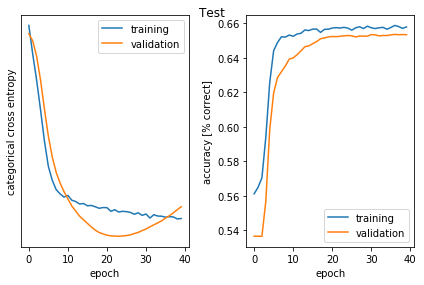

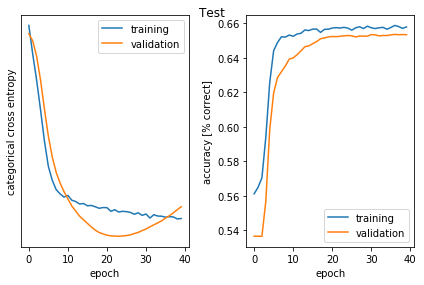

In [18]:
plot_history(history, "Test")

In [19]:
x = (model.predict_classes(test_x_nn)).squeeze()
print(x)
print(accuracy(x, test_bin))
print(np.sum(x==1))
print(np.sum(x==0))
print(np.sum(x==1)/np.sum(x==0))

[1 1 1 ..., 1 1 1]
0.653301231596
6391
4408
1.44986388385


In [20]:
last_n_points = -300
s = 10
n = 5
points = test_x[last_n_points::n]

correct_buy_points = points[(x[last_n_points::n] == 1) & (x[last_n_points::n] == test_bin[last_n_points::n])]
incorrect_buy_points = points[(x[last_n_points::n] == 1) & (x[last_n_points::n] != test_bin[last_n_points::n])]
correct_sell_points = points[(x[last_n_points::n] == 0) & (x[last_n_points::n] == test_bin[last_n_points::n])]
incorrect_sell_points = points[(x[last_n_points::n] == 0) & (x[last_n_points::n] != test_bin[last_n_points::n])]

p = make_plot_figure("BTC Price Predictions", "Time", "Standardized Bitcoin price in USD")

p.line(test_x.Timestamp[last_n_points:], test_x.Smoothed_Price[last_n_points:], line_width=2, line_color='black',  line_alpha=1, legend="12h MA")
p.line(test_x.Timestamp[last_n_points:], test_x.Close[last_n_points:], line_width=2, line_color='black',  line_alpha=0.3, legend="Closing price")
p.triangle(correct_buy_points.Timestamp[::], correct_buy_points.Smoothed_Price[::], color="#00bb00", size=s, legend="Correct buys")
p.triangle(incorrect_buy_points.Timestamp[::], incorrect_buy_points.Smoothed_Price[::], color="#ff0000", size=s,legend="Incorrect buys")
p.inverted_triangle(correct_sell_points.Timestamp[::], correct_sell_points.Smoothed_Price[::], color="#00bb00", size=s,legend="Correct sells")
p.inverted_triangle(incorrect_sell_points.Timestamp[::], incorrect_sell_points.Smoothed_Price[::], color="#ff0000" , size=s,legend="Incorrect sells")
p.xaxis.axis_label="Time"
show(p)

## Investing using the model
We use the model to apply the following simple investment strategy. At the end of each day, we take either a long or short position for $100. No matter what happens, the position is liquidated after 24H. Of course, the choice of the position is dependent on the price increase or decrease of the model

In [21]:
daily_amount = 100 #dollars

def compute_investment_return(prices, decisions):
    prices_in_24h = prices.shift(-DAY_WINDOW)
    return np.sum( ((prices_in_24h - prices)/prices) * daily_amount * decisions)

### The anarchist
The anarchist decide whether to invest or not based on a (bit)coin flip:

In [22]:
sum = 0
prices = test_x.Close
l = len(prices)
for i in range(1000):
    choices = 2 * np.random.choice(2, l) - 1
    sum += compute_investment_return(prices, choices)

print(sum / 1000.0)

-21.05058618374105


### Simple model

In [23]:
l = []
for i in range(0, 48):
    l.append(compute_investment_return(test_x.Close[i::48], (2 * simple_predicted_labels.Binary[i::48]))-1)
    
print("mean", np.mean(l))
print("median", np.median(l))
print("max", np.max(l))
print("min", np.min(l))

mean 11358.1708882
median 11396.3118068
max 13029.9695652
min 9552.59298829


### Neural net

In [24]:
predictions = (model.predict_classes(test_x_nn)).squeeze()
l = []
for i in range(0, 48):
    l.append(compute_investment_return(test_x.Close[i::48],  predictions[i::48]))
    
print("mean", np.mean(l))
print("median", np.median(l))
print("max", np.max(l))
print("min", np.min(l))

mean 6354.05526864
median 6399.72887618
max 7291.77469885
min 5384.53739342
